# Plot the data as in the Sculptor paper

In [1]:
#Import the standard modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits 
from astropy.io import ascii 
from astropy.table import Table, vstack, hstack, join
import math
from math import pi,cos,sin,tan,atan
#from my_fun import tangent
#from my_fun2 import ellipse_rad



In [2]:

from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.special import gammainc


# Density distribution with equally spaced points in logR

In [13]:
def tangent( raref, decref, ra, dec ):
    #Converts ra, dec to tangent plane coordinates.
    #Input/output in degrees

    cotdec=1./(np.tan(np.radians(dec)))
    denom=(np.sin(np.radians(decref))
           + cotdec
           *np.cos(np.radians(decref)) 
           *np.cos(np.radians(ra-raref))
          )
    eta_num=np.cos(np.radians(decref))-(
        cotdec*np.sin(np.radians(decref))*np.cos(np.radians(ra-raref))
    )
    xki_num=cotdec*np.sin(np.radians(ra-raref))

    xki=np.degrees(xki_num/denom)
    eta=np.degrees(eta_num/denom)

    return xki,eta

In [14]:
def elliptical_radius(x, y, a, b, PA):
    """
    Calculate the elliptical radius for a set of x, y coordinates.
    
    Parameters:
    x : ndarray
        x-coordinates of the points.
    y : ndarray
        y-coordinates of the points.
    a : float
        Semi-major axis of the ellipse.
    b : float
        Semi-minor axis of the ellipse.
    PA : float
        Position angle of the ellipse (in radians).
    
    Returns:
    r : ndarray
        The elliptical radius for each set of x, y coordinates.
    """
    
    # Transform x, y into the ellipse's coordinate system
    θ = np.deg2rad(PA)
    x_prime = x * np.cos(θ) + y * np.sin(θ)
    y_prime = -x * np.sin(θ) + y * np.cos(θ)
    
    # Calculate the elliptical radius
    r = np.sqrt((x_prime / a) ** 2 + (y_prime / b) ** 2)
    
    return r

In [43]:
candid =Table.read('../Sculptor.GAIASOURCE.RUWE.VELS.PROB.fits', format='fits')

ra_cand=np.array(candid['ra']) 
dec_cand=np.array(candid['dec'])
prob_cand=np.array(candid['PSAT'])
#rell_cand=12.33*np.array(candid['r_ell'])

good_prob_ind=np.where( prob_cand>0.1 )
        
ra=ra_cand[good_prob_ind]
dec=dec_cand[good_prob_ind]
prob=prob_cand[good_prob_ind]

#These are from Jaclyn

xi_cand = np.array(candid['xi']) 
eta_cand = np.array(candid['eta'])
rell_cand_j = np.array(candid['r_ell'])


In [44]:
#to go in the projected coordinates


rell_cand = elliptical_radius( xi_cand, eta_cand, a, b, 90 - PA)
print(max(rell_cand),'max r_ell candidates')

15.443737961130358 max r_ell candidates


In [45]:
#change the centre of your system
raref=15.039166666666665 
decref=-33.70916666666667

#change these according to your system
ecc=0.37 #1-b/a
a=12.33/60       #radius on the x-axis
b=(1-ecc)*a      #radius on the y-axis
PA=94

rh = 12.33

In [46]:
b

0.129465

In [48]:
#Penarrubia2008 model after the first apocentric passage
pena=Table.read('first_apo.csv', format='ascii', delimiter=',')
pox=np.array(pena['x']) 
poy_ex=np.array(pena['y'])

#change the 5.8 to your system
poy=np.power(10,poy_ex)
por=np.power(10,pox)*5.8  #in arcmin

#Penarrubia2008 model without tides 
pena2=Table.read( 'no_tides.csv', format='ascii', delimiter=',')
pox2=np.array(pena2['x']) 
poy_ex2=np.array(pena2['y'])

#change the 5.8 to your system, it is the core radius
poy2=np.power(10,poy_ex2)
por2=np.power(10,pox2)*5.8  #in arcmin

In [49]:
def model_f(r_mod,a,b):
    return a*np.exp(-r_mod/b)


def exp_a(r_mod,a):
    return a*np.exp(-r_mod/0.6)

In [50]:
#core radius 5.8 \pm 1.6 arcmin
fs1=20
nbins=30
bins=np.logspace(start=np.log10(0.01), stop=np.log10(13.1), num=nbins)


#counts, bins = np.histogram(rell_cand,bins=nbins)
x_bin=np.zeros(nbins-1)
dx_bin=np.zeros(nbins-1)
for i in range(nbins-1):
    
    x_bin[i]=(bins[i+1]+bins[i])/2.0
    dx_bin[i]=(bins[i+1]-bins[i])/2.0
    #print(x_bin[i],i,x_bin[i+1],bins[20])
    


#area_bin=np.zeros(nbins)
#darea_bin=np.zeros(nbins)
surf_dens=np.zeros(nbins-1)
surf_dens_err=np.zeros(nbins-1)
nstars=np.zeros(nbins-1)
#np.pi*a*b


#change the half light radius, here is 12.33 arcmin
for i in range(nbins-1):

    area_big=np.pi*bins[i+1]*(1-ecc)*bins[i+1]
    area_small=np.pi*bins[i]*(1-ecc)*bins[i]
    area_diff=area_big-area_small  #area in unit of r_h^2 or arcmin^2
    if i==0:
        nstars_ind=np.where( (rell_cand<=bins[i+1]) & (rell_cand>=bins[i]) )
    else:
        nstars_ind=np.where( (rell_cand<=bins[i+1]) & (rell_cand>bins[i]) )
        
    nstars_ind_n=np.asarray(nstars_ind)
    nstars[i]=float(len(nstars_ind_n[0]))
    #print(nstars_ind_n)
    #print( np.float(len(nstars_ind_n[0])) )
    
    #surf_dens[i]= nstars[i]/(area_diff) #in number of stars/arcmin^2
    #surf_dens_err[i]= np.sqrt(nstars[i])/(area_diff)
    surf_dens[i]= nstars[i]/(area_diff*rh**2) #in number of stars/arcmin^2
    surf_dens_err[i]= np.sqrt(nstars[i])/(area_diff*rh**2)
    
x_bin_j=np.zeros(nbins-1)
dx_bin_j=np.zeros(nbins-1)
for i in range(nbins-1):
    
    x_bin_j[i]=(bins[i+1]+bins[i])/2.0
    dx_bin_j[i]=(bins[i+1]-bins[i])/2.0

In [51]:
xi = xi_cand
eta = eta_cand

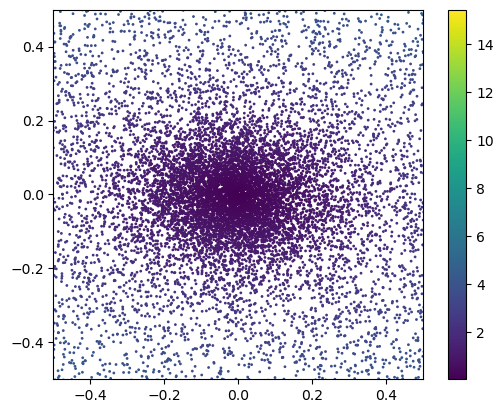

In [52]:
plt.scatter(xi, eta, s=1, c=rell_cand, alpha=1)
r0 = 0.5
plt.xlim(-r0, r0)
plt.ylim(-r0, r0)
plt.gca().set_aspect("equal")
plt.colorbar()

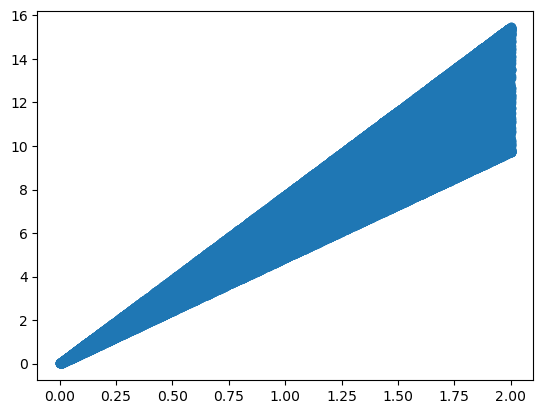

In [53]:
plt.scatter(np.sqrt(xi**2 + eta**2), rell_cand)

Text(0, 0.5, 'number stars')

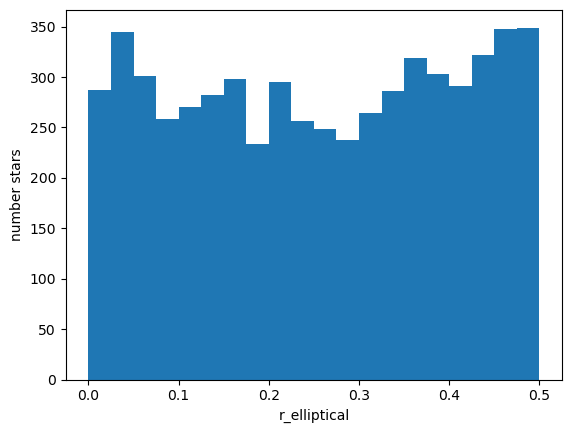

In [54]:
plt.hist(np.log10(rell_cand), 20, range=(0, 0.5))
plt.xlabel("r_elliptical")
plt.ylabel("number stars")

In [29]:
plt.hist(xi / candid["xi"][good_prob_ind], 101, range=(-1, 2))

ValueError: operands could not be broadcast together with shapes (45531,) (7239,) 

In [39]:
#area_bin=np.zeros(nbins)
#darea_bin=np.zeros(nbins)
surf_dens_j=np.zeros(nbins-1)
surf_dens_err_j=np.zeros(nbins-1)
nstars_j=np.zeros(nbins-1)
#np.pi*a*b

for i in range(nbins-1):

    area_big_j=np.pi*bins[i+1]*(1-ecc)*bins[i+1]
    area_small_j=np.pi*bins[i]*(1-ecc)*bins[i]
    area_diff_j=area_big_j-area_small_j  #area in unit of r_h^2 or arcmin^2
    if i==0:
        nstars_ind_j=np.where( (rell_cand<=bins[i+1]) & (rell_cand>=bins[i]) )
    else:
        nstars_ind_j=np.where( (rell_cand<=bins[i+1]) & (rell_cand>bins[i]) )
        
    nstars_ind_n_j=np.asarray(nstars_ind_j)
    nstars_j[i]=float(len(nstars_ind_n_j[0]))
    
    surf_dens_j[i]= nstars_j[i]/(area_diff_j) #in number of stars/arcmin^2
    surf_dens_err_j[i]= np.sqrt(nstars_j[i])/(area_diff_j)



In [40]:
popt_j, pcov_j = curve_fit(exp_a, x_bin[(x_bin*12.33>1) & (x_bin*12.33<25)], surf_dens_j[(x_bin*12.33>1) & (x_bin*12.33<25)])
a_opt_j= popt_j
x_model = np.linspace(0, 10, 1000) #if in r_h
x_model_j =np.logspace(start=np.log10(0.01), stop=np.log10(20), num=1000)
#x_model = np.linspace(0, 150, 10000) #if in arcmin
y_model_j = exp_a(x_model_j, a_opt_j) 

In [41]:

#inner_exp_int=np.interp(x_bin, x_model,y_model, left=None, right=None, period=None)
inner_exp_int_j=np.interp(x_bin, x_model_j,y_model_j, left=None, right=None, period=None)
#outer_exp_int=np.interp(x_bin, x_model,y_model2, left=None, right=None, period=None)


def gamma_m(x,y):
    s=len(x)
    dlogy=np.zeros(s-1)
    dlogx=np.zeros(s-1)
    gamma=np.zeros(s-1)
    x_new=np.zeros(s-1)

    for i in range(s-1):
        dlogy[i]=np.log10(y[i+1]) - np.log10(y[i])
        dlogx[i]=np.log10(x[i+1]) - np.log10(x[i])
        x_new[i]=(x[i+1]+x[i])/2.0
        gamma[i]=dlogy[i]/dlogx[i]
        
    return x_new,gamma#,dlogx,dlogy

def gamma_obs(x,y,dy):
    s=len(x)
    dlogy=np.zeros(s-1)
    dlogx=np.zeros(s-1)
    gamma=np.zeros(s-1)
    x_new=np.zeros(s-1)
    x_new_err=np.zeros(s-1)
    gamma_err=np.zeros(s-1)
    for i in range(s-1):
        dlogy[i]=np.log10(y[i+1]) - np.log10(y[i])
        dlogx[i]=np.log10(x[i+1]) - np.log10(x[i])
        x_new[i]=(x[i+1]+x[i])/2.0
        x_new_err[i]=(x[i+1]-x[i])/2.0
        gamma[i]=dlogy[i]/dlogx[i]
        gamma_err[i]= np.sqrt( np.log10(dy[i+1])**2 + np.log10(dy[i])**2  )/dlogx[i]
        
    return x_new,gamma,x_new_err,gamma_err

    


#x_obs,gamma_obs,x_obs_err,gamma_obs_err=gamma_obs(x_bin, surf_dens, surf_dens_err)
x_obs,gamma_obs=gamma_m(x_bin, surf_dens)
x_obs_j,gamma_obs_j=gamma_m(x_bin_j, surf_dens_j)

#x_inexp,gamma_inexp=gamma_m(x_model, y_model)
x_inexp_j,gamma_inexp_j=gamma_m(x_model_j, y_model_j)


x_pen,gamma_pen=gamma_m(por,poy)
x_pen2,gamma_pen2=gamma_m(por2,poy2)



/var/folders/zf/h7t3p5rj5cv9858z697g6fq40000gn/T/ipykernel_10794/2564595219.py:14: RuntimeWarning: divide by zero encountered in log10
  dlogy[i]=np.log10(y[i+1]) - np.log10(y[i])
/var/folders/zf/h7t3p5rj5cv9858z697g6fq40000gn/T/ipykernel_10794/2564595219.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  gamma[i]=dlogy[i]/dlogx[i]


Text(0, 0.5, '$\\Sigma$ (N/arcmin$^2$)')

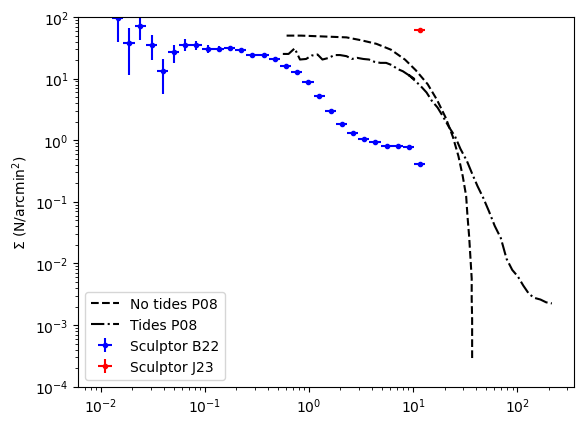

In [42]:
fig, ax1 = plt.subplots()

mul=50
mul2=150
#*1.5
ax1.plot(por2*1.5,poy2*mul, color='black', marker='', linestyle='dashed' ,label='No tides P08')
ax1.plot(por*1.5,poy*mul, color='black', marker='', linestyle='dashdot' ,label='Tides P08')

#ax1.plot(bin_alan*12.33,surf_alan_interp, color='red', marker='o',markersize=25,fillstyle='none',linestyle='' ,label='Sculptor MV20')
#ax1.plot(x_bin_alan*12.33, surf_dens_alan, color='red', marker='o',markersize=40,fillstyle='none',linestyle='' ,label='Sculptor MV20')


ax1.errorbar(x_bin*12.33, surf_dens, yerr=surf_dens_err,xerr=dx_bin ,color='blue', marker='.',linestyle='',label='Sculptor B22')
ax1.errorbar(x_bin_j*12.33, surf_dens_j, yerr=surf_dens_err_j,xerr=dx_bin ,color='red', marker='.',linestyle='',label='Sculptor J23')

ax1.legend(loc="lower left")
ax1.set_yscale('log', nonpositive='clip')
ax1.set_xscale('log', nonpositive='clip')
#plt.xlim(0,10.5) #if in r_h
ax1.set_xlim(1,200) #if in arcmin
ax1.set_ylim(0.0001,100)
#ax1.plot(x_model*12.33, y_model, color='r', linewidth=5,label='Exponential') #inner exponential


#plt.xlabel( '$r_{ell}$ ($r_h$)',fontsize=fs1)
#plt.xlabel( '$r_{ell}$ (arcmin)',fontsize=fs1)
plt.ylabel('$\Sigma$ (N/arcmin$^2$)')


/var/folders/zf/h7t3p5rj5cv9858z697g6fq40000gn/T/ipykernel_10794/1092825653.py:4: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(x_bin_j*12.33, np.log10(surf_dens_j)-np.log10(inner_exp_int_j) , color='red', marker='o',linestyle='-', label='Sculptor J23 - Exponential') #inner exponential


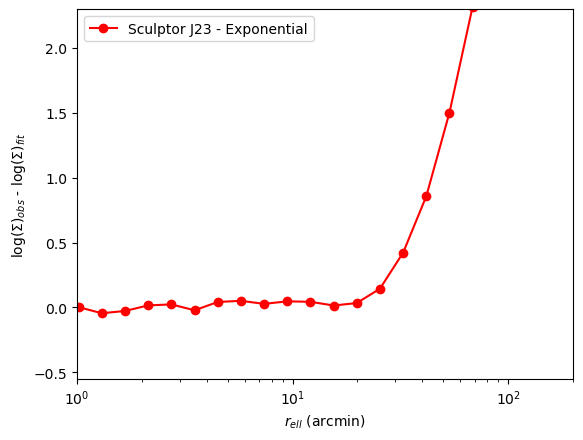

In [36]:

fig, ax3 = plt.subplots()

#ax3.plot(x_bin*12.33, np.log10(surf_dens)-np.log10(inner_exp_int) , color='blue', marker='o',markersize=40,linestyle='-', label='Sculptor B22 - Exponential') #inner exponential
ax3.plot(x_bin_j*12.33, np.log10(surf_dens_j)-np.log10(inner_exp_int_j) , color='red', marker='o',linestyle='-', label='Sculptor J23 - Exponential') #inner exponential

#plt.yscale('log', nonpositive='clip')
plt.xscale('log', nonpositive='clip')
plt.xlim(1,200) #if in arcmin
plt.ylim(-0.55,2.3)

plt.xlabel( '$r_{ell}$ (arcmin)')
plt.ylabel('log($\Sigma$)$_{obs}$ - log($\Sigma$)$_{fit}$')

plt.legend(loc="upper left")


#remove the models P08 for Fornax


(-5.0, 5.666074146829973)

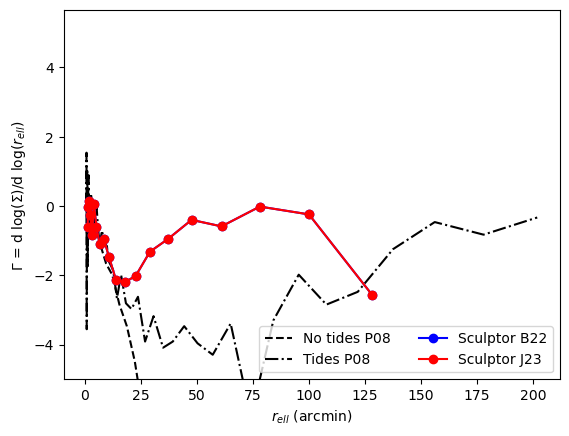

In [38]:
fig, ax5 = plt.subplots()


#lin_grid=np.linspace(0.5, 10.5, 20) #linear grid in r_h
#gamma_obs_lin=np.interp(lin_grid, x_obs,gamma_obs, left=None, right=None, period=None)

#lin_grid_al=np.linspace(0.5, 6.5, 14) #linear grid in r_h
#gamma_al_lin=np.interp(lin_grid_al, x_al,gamma_al, left=None, right=None, period=None)

#ax5.plot(x_inexp*12.33,gamma_inexp, color='r', linewidth=5, label='Exponential') #inner exponential
#*1.5
ax5.plot(x_pen2*1.5,gamma_pen2, color='black', marker='',markersize=5,linestyle='dashed', label='No tides P08') 
ax5.plot(x_pen*1.5,gamma_pen, color='black', marker='',markersize=5,linestyle='dashdot', label='Tides P08')


ax5.plot(x_obs[x_obs*12.33>1]*12.33,gamma_obs[x_obs*12.33>1], color='b', marker='o',linestyle='-',label='Sculptor B22') 

ax5.plot(x_obs_j[x_obs_j*12.33>1]*12.33,gamma_obs_j[x_obs_j*12.33>1], color='r', marker='o',linestyle='-',label='Sculptor J23') 



#plt.xlabel( '$r_{ell}$ ($r_h$)',fontsize=fs1)
plt.xlabel( '$r_{ell}$ (arcmin)')
plt.ylabel('$\Gamma$ = d log($\Sigma$)/d log($r_{ell}$) ')
plt.legend(ncol=2,loc="lower right")
plt.ylim(-5)

In [170]:
disp_v=9.2 #kms
tperi=0.41 #Gyr
coe=0.55

break_r= 0.55*tperi* 31556952.0*1e9*disp_v*3.2407792896664e-17 #in kpc

print(break_r,'kpc')


dist_umi=86.0 #kpc
rh_umi=12.33 #arcmin

break_arc= np.rad2deg( np.arctan(break_r/dist_umi) )*60.0
print(break_arc,'arcmin')
print(break_arc/12.33,'rh')

2.1216750906309345 kpc
84.79421474372823 arcmin
6.877065267131243 rh
